# 📊 Modelo Lineal - Clasificación de Imágenes OCT
## Regresión Logística para Clasificación Multiclase

---

En este notebook aplicaremos un **modelo lineal** (Regresión Logística) para clasificar imágenes OCT retinales.

### 📦 Dataset:
- **Fuente:** Kermany et al. 2018 Mendeley Data V3
- **Total:** 109,309 imágenes JPEG
- **Split:** 70% train (~76,500), 20% val (~21,900), 10% test (~10,900)
- **Clases:** CNV, DME, DRUSEN, NORMAL

### 🎯 Características del Modelo Lineal:
- **Tipo:** Regresión Logística Multinomial (LogisticRegression de sklearn)
- **Características:** Las imágenes se redimensionan a 64×64 y se aplanan en vectores 1D
- **No hay capas ocultas**: Es un modelo simple y rápido
- **Interpretabilidad:** Alta, podemos ver los pesos por píxel
- **Optimización de memoria:** Imágenes reducidas a 64×64 para caber en RAM
- **Subset de datos:** Usaremos solo 50% del train (~38,250 imágenes) para optimizar memoria

---

## 1. 📥 Carga de Datos con Data Loaders

Primero cargamos los datos usando los data loaders que ya configuramos.

In [19]:
# ============================================================================
# IMPORTACIÓN DE LIBRERÍAS
# ============================================================================
import os

# Silenciar logs informativos de TensorFlow (debe ir antes de importar tf)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0=all, 1=filter INFO, 2=filter WARNING, 3=filter ERROR

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Importar módulo de dataloaders (solo si se ejecuta localmente)
# Si estás en Colab, comenta la siguiente línea y ejecuta la celda de funciones más abajo
try:
    import oct_dataloader as dataloaders
    print("✅ Módulo oct_dataloader importado (ejecución local)")
except ImportError:
    print("⚠️  oct_dataloader no encontrado - usar funciones embebidas para Colab")
    dataloaders = None

# Configuración
np.random.seed(42)
plt.style.use('default')
sns.set_palette("husl")

print("✅ Librerías importadas correctamente")

✅ Módulo oct_dataloader importado (ejecución local)
✅ Librerías importadas correctamente


### 📝 Nota para Google Colab:
Si ejecutas este notebook en **Google Colab**, ejecuta la celda siguiente para definir las funciones necesarias del dataloader.

Si ejecutas **localmente** (tienes el archivo `oct_dataloader.py`), puedes saltarte la siguiente celda.

In [20]:
# ============================================================================
# FUNCIONES DE DATALOADER EMBEBIDAS (PARA GOOGLE COLAB)
# ============================================================================
# Solo ejecuta esta celda si estás en Colab o no tienes el archivo oct_dataloader.py

if dataloaders is None:
    from typing import Tuple, Optional
    
    class dataloaders:
        @staticmethod
        def create_oct_dataloaders(
            data_path: str,
            img_size: Tuple[int, int] = (224, 224),
            batch_size: int = 32,
            train_subset_fraction: float = 1.0,
            seed: int = 42,
            validation_split: Optional[float] = None,
            optimize: bool = True,
            verbose: bool = True
        ):
            """Crea dataloaders para el dataset OCT con configuración flexible."""
            
            class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
            
            if verbose:
                print("⚙️ Configuración de DataLoaders")
                print(f"   • Tamaño de imagen: {img_size}")
                print(f"   • Batch size: {batch_size}")
                print(f"   • Clases: {class_names}")
                print(f"   • Train subset: {train_subset_fraction*100:.1f}%")
                print(f"   • Seed: {seed}\n")
            
            # DATA LOADER DE ENTRENAMIENTO
            train_path = os.path.join(data_path, 'train')
            
            if not os.path.exists(train_path):
                raise ValueError(f"No se encontró la carpeta de entrenamiento en: {train_path}")
            
            if verbose:
                print("📦 Creando data loader de entrenamiento...")
            
            train_dataset = tf.keras.utils.image_dataset_from_directory(
                train_path,
                labels='inferred',
                label_mode='int',
                class_names=class_names,
                color_mode='rgb',
                batch_size=batch_size,
                image_size=img_size,
                shuffle=True,
                seed=seed
            )
            
            if train_subset_fraction < 1.0:
                total_batches = tf.data.experimental.cardinality(train_dataset).numpy()
                subset_batches = max(1, int(total_batches * train_subset_fraction))
                train_dataset = train_dataset.take(subset_batches)
                
                if verbose:
                    print(f"   ⚠️  Usando {train_subset_fraction*100:.1f}% del dataset de entrenamiento")
                    print(f"   ⚠️  Batches: {subset_batches} de {total_batches}")
            
            if optimize:
                train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
                if verbose:
                    print(f"✅ Data loader de entrenamiento creado (con optimización)")
            else:
                if verbose:
                    print(f"✅ Data loader de entrenamiento creado")
            
            # DATA LOADER DE VALIDACIÓN
            val_path = os.path.join(data_path, 'val')
            val_dataset = None
            
            if os.path.exists(val_path):
                if verbose:
                    print("\n📦 Creando data loader de validación...")
                
                val_dataset = tf.keras.utils.image_dataset_from_directory(
                    val_path,
                    labels='inferred',
                    label_mode='int',
                    class_names=class_names,
                    color_mode='rgb',
                    batch_size=batch_size,
                    image_size=img_size,
                    shuffle=False
                )
                
                if optimize:
                    val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
                    if verbose:
                        print(f"✅ Data loader de validación creado (con optimización)")
                else:
                    if verbose:
                        print(f"✅ Data loader de validación creado")
            
            # DATA LOADER DE PRUEBA
            test_path = os.path.join(data_path, 'test')
            test_dataset = None
            
            if os.path.exists(test_path):
                if verbose:
                    print("\n📦 Creando data loader de prueba...")
                
                test_dataset = tf.keras.utils.image_dataset_from_directory(
                    test_path,
                    labels='inferred',
                    label_mode='int',
                    class_names=class_names,
                    color_mode='rgb',
                    batch_size=batch_size,
                    image_size=img_size,
                    shuffle=False
                )
                
                if optimize:
                    test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
                    if verbose:
                        print(f"✅ Data loader de prueba creado (con optimización)")
                else:
                    if verbose:
                        print(f"✅ Data loader de prueba creado")
            
            if verbose:
                print("\n" + "="*60)
                print("📊 RESUMEN DE DATASETS")
                print("="*60)
                
                if train_dataset:
                    train_cardinality = tf.data.experimental.cardinality(train_dataset).numpy()
                    print(f"Train:      {train_cardinality} batches")
                
                if val_dataset:
                    val_cardinality = tf.data.experimental.cardinality(val_dataset).numpy()
                    print(f"Validation: {val_cardinality} batches")
                
                if test_dataset:
                    test_cardinality = tf.data.experimental.cardinality(test_dataset).numpy()
                    print(f"Test:       {test_cardinality} batches")
                
                print("="*60 + "\n")
            
            return train_dataset, val_dataset, test_dataset, class_names
        
        @staticmethod
        def dataloader_to_arrays(dataset, dataset_name="Dataset", limit=None):
            """Convierte un tf.data.Dataset a arrays numpy (X, y)."""
            
            X_list = []
            y_list = []
            total_samples = 0
            
            print(f"🔄 Convirtiendo {dataset_name} a arrays numpy...")
            
            for images, labels in dataset:
                X_list.append(images.numpy())
                y_list.append(labels.numpy())
                total_samples += images.shape[0]
                
                if limit is not None and total_samples >= limit:
                    print(f"   ⚠️  Límite alcanzado: {total_samples} muestras")
                    break
                
                if len(X_list) % 100 == 0:
                    print(f"   Procesados {len(X_list)} batches ({total_samples} muestras)...")
            
            X = np.concatenate(X_list, axis=0)
            y = np.concatenate(y_list, axis=0)
            
            if limit is not None and X.shape[0] > limit:
                X = X[:limit]
                y = y[:limit]
            
            print(f"✅ {dataset_name}: {X.shape[0]:,} muestras")
            print(f"   Shape: {X.shape}")
            
            return X, y
    
    print("✅ Funciones de dataloader cargadas para Colab")
else:
    print("ℹ️  Usando módulo oct_dataloader.py (ejecución local)")

ℹ️  Usando módulo oct_dataloader.py (ejecución local)


In [21]:
# ============================================================================
# CARGAR DATASET CON KAGGLEHUB
# ============================================================================
import kagglehub

# Descargar dataset actualizado
# Dataset: Kermany et al. 2018 Mendeley Data V3
# Total: 109,309 imágenes JPEG
# Split: 70% train, 20% val, 10% test
path = kagglehub.dataset_download("anirudhcv/labeled-optical-coherence-tomography-oct")

print(f"📦 Dataset descargado en: {path}")

# Buscar la estructura correcta del dataset (puede tener subcarpetas)
data_path = path
for root, dirs, files in os.walk(path):
    if 'train' in dirs and 'test' in dirs:
        data_path = root
        print(f"✅ Estructura de datos encontrada en: {data_path}")
        break

# Verificar que encontramos las carpetas
if os.path.exists(os.path.join(data_path, 'train')):
    print(f"   ✓ Carpeta train encontrada")
if os.path.exists(os.path.join(data_path, 'val')):
    print(f"   ✓ Carpeta val encontrada")
if os.path.exists(os.path.join(data_path, 'test')):
    print(f"   ✓ Carpeta test encontrada")

📦 Dataset descargado en: /home/palodo2/.cache/kagglehub/datasets/anirudhcv/labeled-optical-coherence-tomography-oct/versions/2
✅ Estructura de datos encontrada en: /home/palodo2/.cache/kagglehub/datasets/anirudhcv/labeled-optical-coherence-tomography-oct/versions/2/Dataset - train+val+test
   ✓ Carpeta train encontrada
   ✓ Carpeta val encontrada
   ✓ Carpeta test encontrada


## 2. ⚙️ Configuración de Data Loaders

Creamos los data loaders para cargar imágenes eficientemente.

In [22]:
# ============================================================================
# CONFIGURACIÓN DE DATA LOADERS
# ============================================================================

# Parámetros - Reducimos tamaño para optimizar memoria
IMG_SIZE = (64, 64)  # Imágenes más pequeñas para caber en RAM
BATCH_SIZE = 32

# Crear dataloaders usando oct_dataloader
train_dataset, val_dataset, test_dataset, class_names = dataloaders.create_oct_dataloaders(
    data_path=data_path,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=42,
    verbose=True,
    train_subset_fraction=0.4,  # Usar solo el 40% del dataset de entrenamiento para optimizar memoria
)

print(f"\n✅ DataLoaders creados correctamente")
print(f"   Clases: {class_names}")

⚙️ Configuración de DataLoaders
   • Tamaño de imagen: (64, 64)
   • Batch size: 32
   • Clases: ['CNV', 'DME', 'DRUSEN', 'NORMAL']
   • Train subset: 40.0%
   • Seed: 42

📦 Creando data loader de entrenamiento...
Found 76515 files belonging to 4 classes.
   ⚠️  Usando 40.0% del dataset de entrenamiento
   ⚠️  Batches: 956 de 2392
✅ Data loader de entrenamiento creado (con optimización)

📦 Creando data loader de validación...
Found 21861 files belonging to 4 classes.
✅ Data loader de validación creado (con optimización)

📦 Creando data loader de prueba...
Found 10933 files belonging to 4 classes.
✅ Data loader de prueba creado (con optimización)

📊 RESUMEN DE DATASETS
Train:      956 batches
Validation: 684 batches
Test:       342 batches


✅ DataLoaders creados correctamente
   Clases: ['CNV', 'DME', 'DRUSEN', 'NORMAL']


## 3. 🔄 Conversión de Datos para Modelo Lineal

Convertimos las imágenes de los data loaders a arrays numpy y las aplanamos para la regresión logística.

In [23]:
# ============================================================================
# CONVERTIR DATA LOADERS A ARRAYS (CON LÍMITE PARA TRAIN PARA OPTIMIZAR MEMORIA)
# ============================================================================

print("=" * 70)
print("CONVIRTIENDO DATA LOADERS A ARRAYS")
print("=" * 70)


# Convertir todos los datasets
# IMPORTANTE: train_dataset usa limit para tomar solo la mitad de los datos
X_train, y_train = dataloaders.dataloader_to_arrays(
    train_dataset, 
    "Train"
)

X_val, y_val = dataloaders.dataloader_to_arrays(
    val_dataset, 
    "Validación"
)

X_test, y_test = dataloaders.dataloader_to_arrays(
    test_dataset, 
    "Test"
)

print("\n✅ Conversión completada")
print(f"\nTotal de features por imagen: {X_train.shape[1]:,} (64 × 64 × 3)")
print(f"Datos de entrenamiento: {X_train.shape[0]:,} muestras (40% del total)")

CONVIRTIENDO DATA LOADERS A ARRAYS
🔄 Convirtiendo Train a arrays numpy...
   Procesados 100 batches (3200 muestras)...
   Procesados 200 batches (6400 muestras)...
   Procesados 300 batches (9600 muestras)...
   Procesados 400 batches (12800 muestras)...
   Procesados 500 batches (16000 muestras)...
   Procesados 600 batches (19200 muestras)...
   Procesados 700 batches (22400 muestras)...
   Procesados 800 batches (25600 muestras)...
   Procesados 900 batches (28800 muestras)...
✅ Train: 30,592 muestras
   Shape: (30592, 64, 64, 3)
🔄 Convirtiendo Validación a arrays numpy...
   Procesados 100 batches (3200 muestras)...
   Procesados 200 batches (6400 muestras)...
   Procesados 300 batches (9600 muestras)...
   Procesados 400 batches (12800 muestras)...
   Procesados 500 batches (16000 muestras)...
   Procesados 600 batches (19200 muestras)...
✅ Validación: 21,861 muestras
   Shape: (21861, 64, 64, 3)
🔄 Convirtiendo Test a arrays numpy...
   Procesados 100 batches (3200 muestras)...
  

---

## 3.5 🔄 Aplanar Imágenes

Para poder usar un modelo lineal (Regresión Logística), necesitamos convertir las imágenes 2D en vectores 1D.

In [24]:
# ============================================================================
# APLANAR IMÁGENES PARA MODELO LINEAL
# ============================================================================

print("\n" + "=" * 70)
print("APLANANDO IMÁGENES")
print("=" * 70)

# Las imágenes vienen como (n_samples, height, width, channels)
# Las aplanamos a (n_samples, height * width * channels)

print(f"\nShape original:")
print(f"   X_train: {X_train.shape}")
print(f"   X_val:   {X_val.shape}")
print(f"   X_test:  {X_test.shape}")

# Aplanar
n_train = X_train.shape[0]
n_val = X_val.shape[0]
n_test = X_test.shape[0]

X_train = X_train.reshape(n_train, -1)
X_val = X_val.reshape(n_val, -1)
X_test = X_test.reshape(n_test, -1)

print(f"\nShape después de aplanar:")
print(f"   X_train: {X_train.shape} ({n_train:,} muestras × {X_train.shape[1]:,} features)")
print(f"   X_val:   {X_val.shape} ({n_val:,} muestras × {X_val.shape[1]:,} features)")
print(f"   X_test:  {X_test.shape} ({n_test:,} muestras × {X_test.shape[1]:,} features)")

print("\n✅ Imágenes aplanadas correctamente")


APLANANDO IMÁGENES

Shape original:
   X_train: (30592, 64, 64, 3)
   X_val:   (21861, 64, 64, 3)
   X_test:  (10933, 64, 64, 3)

Shape después de aplanar:
   X_train: (30592, 12288) (30,592 muestras × 12,288 features)
   X_val:   (21861, 12288) (21,861 muestras × 12,288 features)
   X_test:  (10933, 12288) (10,933 muestras × 12,288 features)

✅ Imágenes aplanadas correctamente


---

## 4. 🤖 Entrenamiento del Modelo Lineal

Entrenamos un modelo de **Regresión Logística Multinomial** con los datos aplanados.

In [25]:
# ============================================================================
# ENTRENAR MODELO DE REGRESIÓN LOGÍSTICA
# ============================================================================

print("=" * 70)
print("🎓 ENTRENANDO MODELO LINEAL (REGRESIÓN LOGÍSTICA)")
print("=" * 70)

# Crear el modelo
# max_iter aumentado para asegurar convergencia
# multi_class se detecta automáticamente para clasificación multiclase
modelo_lineal = LogisticRegression(
    max_iter=200,
    solver='lbfgs',
    random_state=42,
    verbose=1,
    n_jobs=-1  # Usar todos los cores disponibles
)

# Entrenar el modelo
print("\n🚀 Entrenando...")
print("   (Esto puede tomar varios minutos...)\n")
modelo_lineal.fit(X_train, y_train)

print("\n✅ Modelo entrenado correctamente")

# Información del modelo
print("\n" + "=" * 70)
print("📊 INFORMACIÓN DEL MODELO")
print("=" * 70)
print(f"   • Tipo: Regresión Logística Multinomial")
print(f"   • Número de clases: {len(modelo_lineal.classes_)}")
print(f"   • Clases: {modelo_lineal.classes_}")
print(f"   • Forma de coeficientes: {modelo_lineal.coef_.shape}")
print(f"   • Número de parámetros: {modelo_lineal.coef_.size + modelo_lineal.intercept_.size:,}")
print(f"   • Solver: {modelo_lineal.solver}")
print(f"   • Iteraciones realizadas: {modelo_lineal.n_iter_}")

🎓 ENTRENANDO MODELO LINEAL (REGRESIÓN LOGÍSTICA)

🚀 Entrenando...
   (Esto puede tomar varios minutos...)


✅ Modelo entrenado correctamente

📊 INFORMACIÓN DEL MODELO
   • Tipo: Regresión Logística Multinomial
   • Número de clases: 4
   • Clases: [0 1 2 3]
   • Forma de coeficientes: (4, 12288)
   • Número de parámetros: 49,156
   • Solver: lbfgs
   • Iteraciones realizadas: [200]


## 5. 📈 Evaluación del Modelo

Evaluamos el modelo en los tres conjuntos: entrenamiento, validación y test.

In [26]:
# ============================================================================
# FUNCIÓN DE EVALUACIÓN
# ============================================================================

def evaluar_modelo(modelo, X, y, conjunto_nombre):
    """
    Evalúa el modelo en un conjunto de datos.
    """
    print(f"\n{'=' * 70}")
    print(f"📊 EVALUACIÓN EN {conjunto_nombre.upper()}")
    print('=' * 70)
    
    # Predicciones
    print(f"Prediciendo...")
    y_pred = modelo.predict(X)
    
    # Métricas
    accuracy = accuracy_score(y, y_pred)
    print(f"\n✅ Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Reporte de clasificación
    print(f"\n📋 Reporte de Clasificación:")
    print("-" * 70)
    class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
    report = classification_report(y, y_pred, target_names=class_names, digits=4)
    print(report)
    
    return accuracy, y_pred

# Evaluar en los tres conjuntos
acc_train, y_pred_train = evaluar_modelo(modelo_lineal, X_train, y_train, "Entrenamiento")
acc_val, y_pred_val = evaluar_modelo(modelo_lineal, X_val, y_val, "Validación")
acc_test, y_pred_test = evaluar_modelo(modelo_lineal, X_test, y_test, "Test")


📊 EVALUACIÓN EN ENTRENAMIENTO
Prediciendo...

✅ Accuracy: 0.6879 (68.79%)

📋 Reporte de Clasificación:
----------------------------------------------------------------------
              precision    recall  f1-score   support

         CNV     0.6928    0.7244    0.7083     10319
         DME     0.5536    0.2591    0.3530      3308
      DRUSEN     0.5414    0.1521    0.2375      2537
      NORMAL     0.7027    0.8543    0.7711     14428

    accuracy                         0.6879     30592
   macro avg     0.6226    0.4975    0.5175     30592
weighted avg     0.6699    0.6879    0.6604     30592


📊 EVALUACIÓN EN VALIDACIÓN
Prediciendo...

✅ Accuracy: 0.6024 (60.24%)

📋 Reporte de Clasificación:
----------------------------------------------------------------------
              precision    recall  f1-score   support

         CNV     0.6066    0.6286    0.6174      7491
         DME     0.2723    0.1380    0.1832      2319
      DRUSEN     0.1938    0.0457    0.0739      1773
 

## 6. 📊 Visualización de Resultados

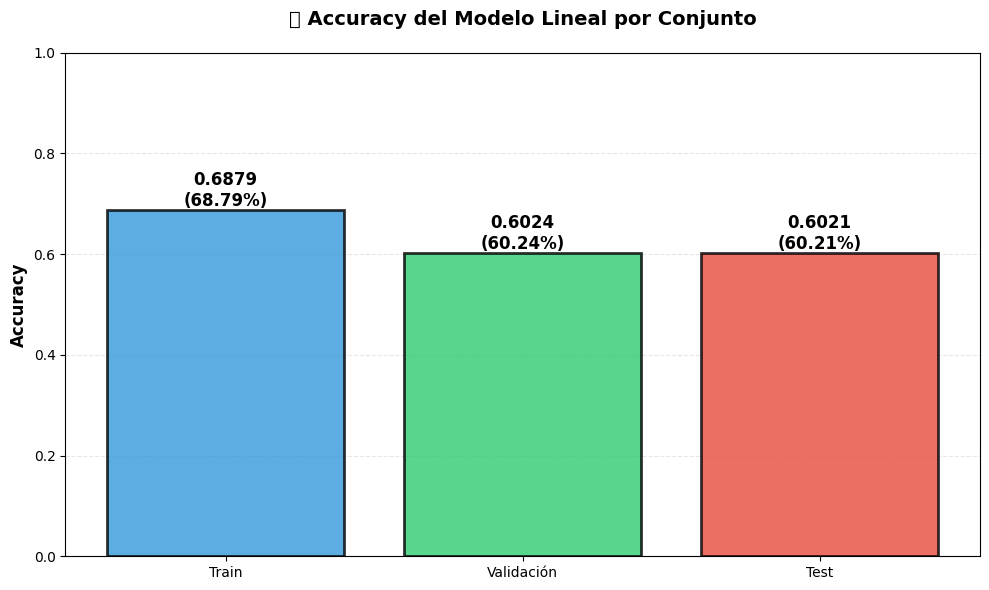

In [27]:
# ============================================================================
# GRÁFICO DE BARRAS CON ACCURACIES
# ============================================================================

fig, ax = plt.subplots(figsize=(10, 6))

conjuntos = ['Train', 'Validación', 'Test']
accuracies = [acc_train, acc_val, acc_test]
colores = ['#3498db', '#2ecc71', '#e74c3c']

bars = ax.bar(conjuntos, accuracies, color=colores, alpha=0.8, edgecolor='black', linewidth=2)

# Añadir valores sobre las barras
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.4f}\n({acc*100:.2f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('📊 Accuracy del Modelo Lineal por Conjunto', fontsize=14, fontweight='bold', pad=20)
ax.set_ylim([0, 1.0])
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

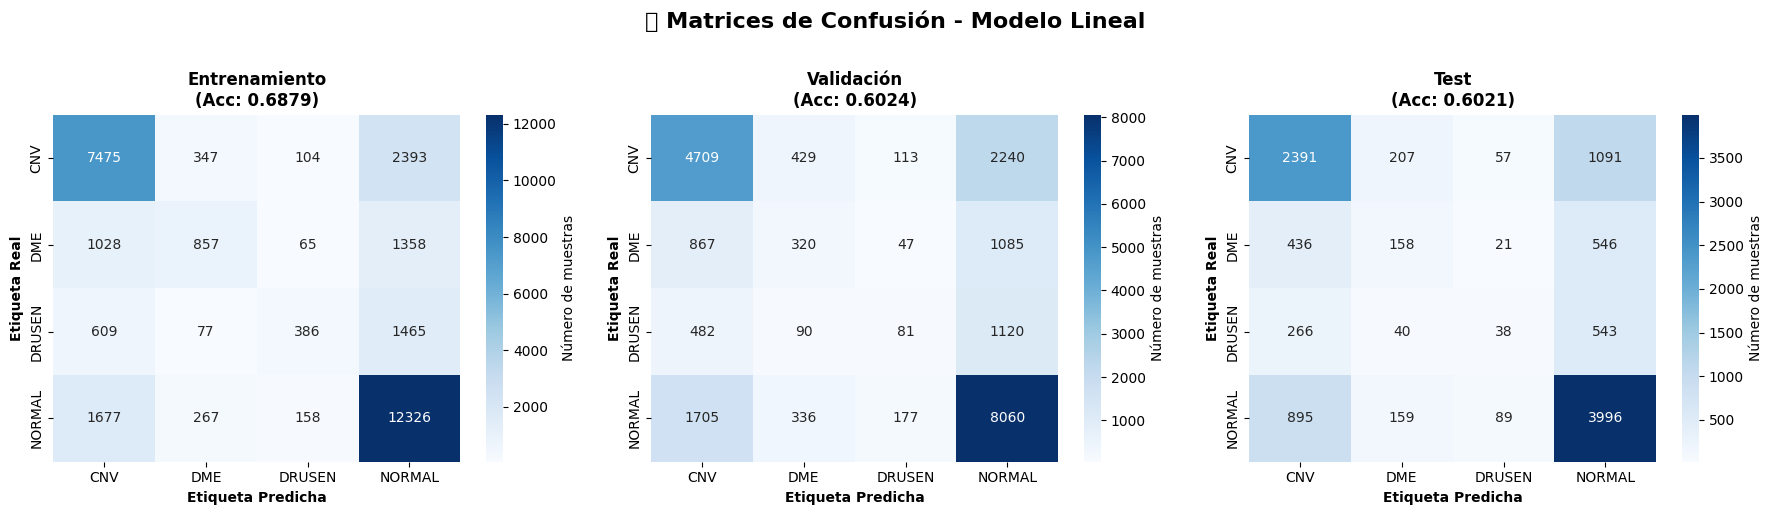

In [28]:
# ============================================================================
# MATRICES DE CONFUSIÓN
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('🔍 Matrices de Confusión - Modelo Lineal', fontsize=16, fontweight='bold', y=1.02)

class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
datasets = [
    (y_train, y_pred_train, 'Entrenamiento', axes[0]),
    (y_val, y_pred_val, 'Validación', axes[1]),
    (y_test, y_pred_test, 'Test', axes[2])
]

for y_true, y_pred, titulo, ax in datasets:
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Número de muestras'})
    ax.set_title(f'{titulo}\n(Acc: {accuracy_score(y_true, y_pred):.4f})', 
                 fontweight='bold', fontsize=12)
    ax.set_ylabel('Etiqueta Real', fontweight='bold')
    ax.set_xlabel('Etiqueta Predicha', fontweight='bold')

plt.tight_layout()
plt.show()

---

## 7. 📋 Tabla de Resultados Final

Resumen de los resultados para incluir en el README.

In [29]:
# ============================================================================
# CREAR TABLA DE RESULTADOS
# ============================================================================

print("\n" + "=" * 70)
print(" " * 20 + "📊 RESULTADOS FINALES")
print("=" * 70)

# Número de parámetros
n_params = modelo_lineal.coef_.size + modelo_lineal.intercept_.size

resultados = {
    'Modelo': ['Modelo Lineal (Regresión Logística)'],
    'Parámetros': [f'{n_params:,}'],
    'Acc Train': [f'{acc_train:.4f}'],
    'Acc Validación': [f'{acc_val:.4f}'],
    'Acc Test': [f'{acc_test:.4f}']
}

df_resultados = pd.DataFrame(resultados)
print("\n")
print(df_resultados.to_string(index=False))
print("\n" + "=" * 70)

# Guardar también en formato markdown para el README
print("\n📄 Formato Markdown para README:")
print("\n```markdown")
print("| Modelo | Parámetros | Acc Train | Acc Validación | Acc Test |")
print("|--------|------------|-----------|----------------|----------|")
print(f"| Modelo Lineal (Regresión Logística) | {n_params:,} | {acc_train:.4f} | {acc_val:.4f} | {acc_test:.4f} |")
print("```")


                    📊 RESULTADOS FINALES


                             Modelo Parámetros Acc Train Acc Validación Acc Test
Modelo Lineal (Regresión Logística)     49,156    0.6879         0.6024   0.6021


📄 Formato Markdown para README:

```markdown
| Modelo | Parámetros | Acc Train | Acc Validación | Acc Test |
|--------|------------|-----------|----------------|----------|
| Modelo Lineal (Regresión Logística) | 49,156 | 0.6879 | 0.6024 | 0.6021 |
```
